<a href="https://colab.research.google.com/github/otavioml/Chess-Data-Analysis/blob/main/Chess_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
plt.rcParams['figure.figsize']  = (16, 14)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lichess_2013_2014_Complete.csv', quoting=csv.QUOTE_NONE, error_bad_lines=False, warn_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Limpeza dos dados
#Padronização do tipo da coluna Numer_of_Moves
df['Number_of_Moves'] =  pd.to_numeric(df['Number_of_Moves'], errors='coerce')

#Remoção das partidas com menos de 3 movimentos que foram abandonadas ou terminadas por tempo
condition = (df['Number_of_Moves'] >= 3) | (df['Termination'] == 'Normal')
df = df.loc[condition]

#limpeza das linhas nulas
df = df.dropna()


In [ ]:
#Removing outliers using zscore
#df['IT_Zscore'] = stats.zscore(df['InitialTime'])
#df['Inc_Zscore'] = stats.zscore(df['Increment'])
#condition = (df['IT_Zscore'] <= 3) & (df['Inc_Zscore'] <= 3)
#df = df.loc[condition]

In [6]:
#Adição das colunas média e razão
df['RatioElo'] = df['BlackElo']/df['WhiteElo']
df['MatchElo'] = (df['BlackElo']+df['WhiteElo'])/2

#Colunas de interesse
df = df[['WhiteElo','BlackElo','RatioElo','MatchElo','Winner','InitialTime','Increment','TimeControl','Opening','ECO','Number_of_Moves']]
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(13027101, 11)

In [7]:
df.head()

,WhiteElo,BlackElo,RatioElo,MatchElo,Winner,InitialTime,Increment,TimeControl,Opening,ECO,Number_of_Moves
0,1639,1403,0.856010,1521.0,White,600,8,Rapid,French Defense: Normal Variation,C00,13.0
1,1643,1747,1.063299,1695.0,White,420,17,Rapid,Four Knights Game: Italian Variation,C50,11.0
2,1824,1973,1.081689,1898.5,Black,60,1,Bullet,Caro-Kann Defense: Goldman Variation,B12,47.0
3,1765,1815,1.028329,1790.0,Black,60,1,Bullet,French Defense: La Bourdonnais Variation,C00,23.0
4,1477,1487,1.006770,1482.0,White,300,3,Blitz,Owen Defense,B00,32.0


In [8]:
#Short description of the dataframe
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,WhiteElo,BlackElo,RatioElo,MatchElo,InitialTime,Increment,Number_of_Moves
count,13027101.00,13027101.00,13027101.00,13027101.00,13027101.00,13027101.00,13027101.00
mean,1615.47,1608.59,1.00,1612.03,307.91,2.35,34.16
std,228.36,232.16,0.13,207.51,373.59,5.46,15.74
min,511.00,704.00,0.35,785.50,0.00,0.00,1.00
25%,1464.00,1456.00,0.93,1469.50,120.00,0.00,23.00
50%,1612.00,1604.00,1.00,1605.00,300.00,0.00,32.00
75%,1765.00,1760.00,1.07,1747.50,360.00,3.00,43.00
max,2970.00,2970.00,2.94,2676.50,10800.00,180.00,227.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a78fd3690>,
      dtype=object)

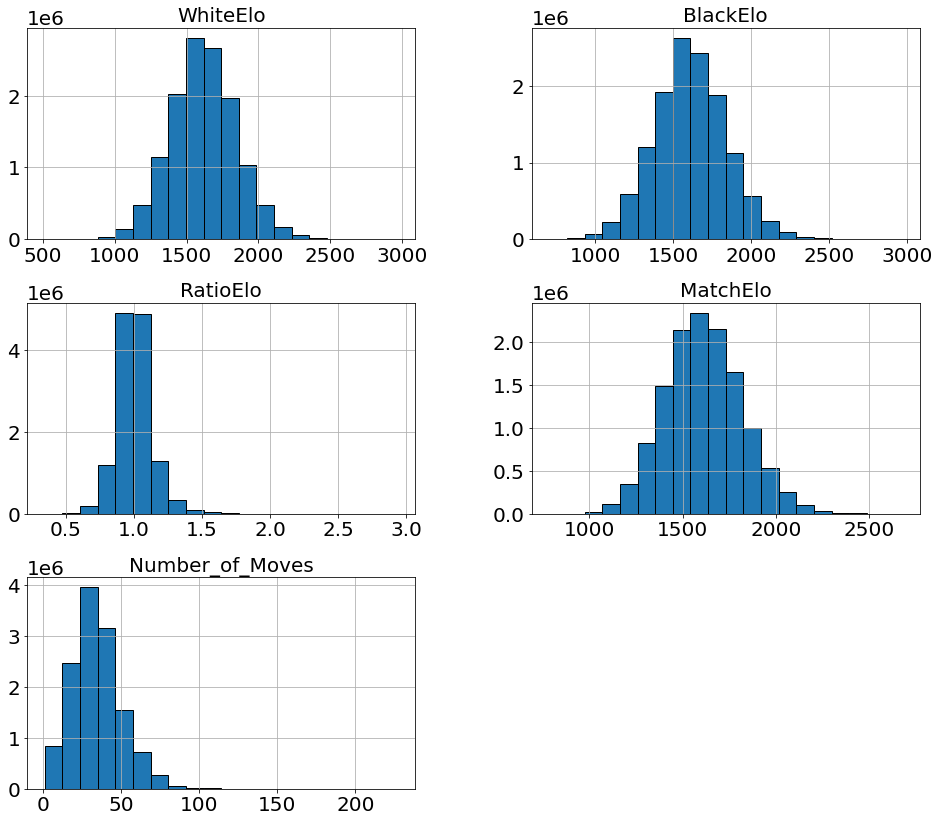

In [9]:
df.hist(bins=20, column=['WhiteElo', 'BlackElo', 'RatioElo', 'MatchElo', 'Number_of_Moves'],edgecolor='black',)

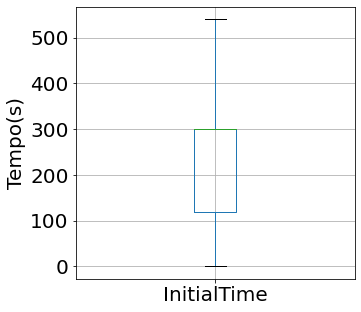

In [34]:
df.boxplot(column=['InitialTime'], showfliers=False, figsize=(5,5))
plt.ylabel('Tempo(s)')
plt.show()

In [14]:
#Removing outliers using zscore
df['IT_Zscore'] = stats.zscore(df['InitialTime'])
df['Inc_Zscore'] = stats.zscore(df['Increment'])
condition = (df['IT_Zscore'] <= 3) & (df['Inc_Zscore'] <= 3)
df = df.loc[condition]

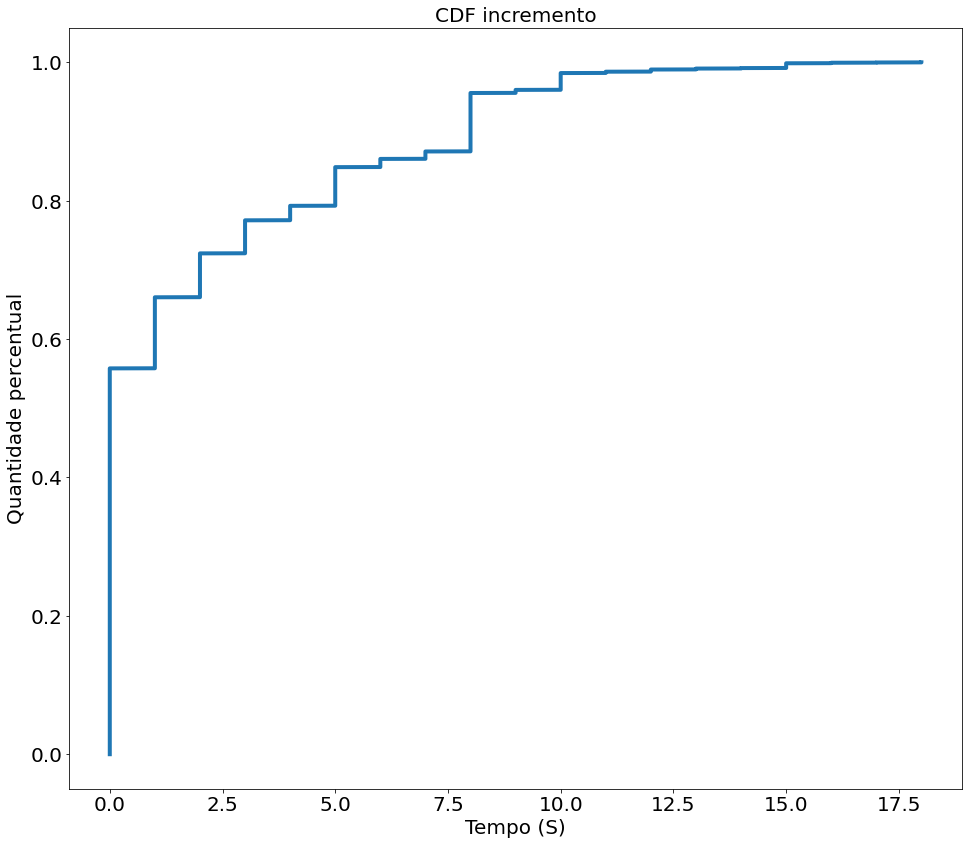

In [41]:
from statsmodels.distributions.empirical_distribution import ECDF
cdf = ECDF(df['Increment'])
plt.title('CDF incremento')
plt.ylabel('Quantidade percentual')
plt.xlabel("Tempo (S)")
plt.plot(cdf.x,cdf.y)
plt.show()

In [59]:
#10 most frequent opening
df_countWhiteWins = df.groupby(['ECO']).count().sort_values('Winner', ascending=False)['Winner'][0:10]
df_countWhiteWins

ECO
A00    1130715
C00     800429
A40     716806
B01     595793
D00     583286
C41     526765
B00     480163
C20     472637
B20     367894
B06     301888
Name: Winner, dtype: int64

In [44]:
#Average moves per
df_averageMovesPerGame = df['Number_of_Moves'].mean()
df_averageMovesPerGame

34.215125999459524

<BarContainer object of 3 artists>

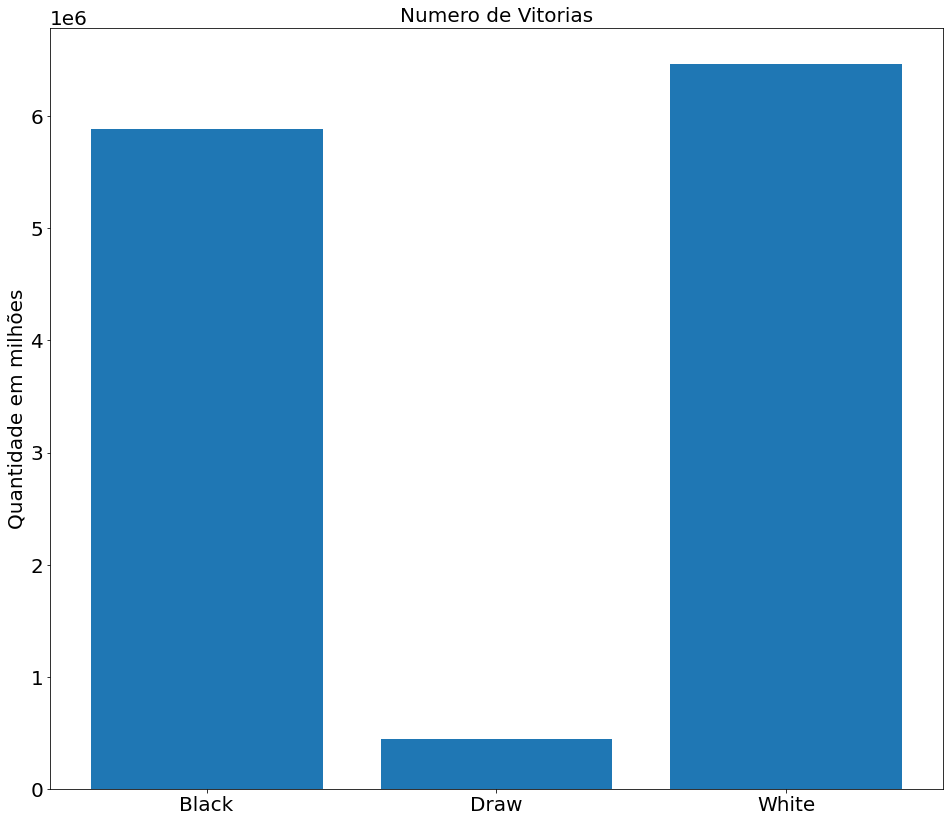

In [57]:
df_winner = df.groupby('Winner').count()['ECO']
plt.ylabel('Quantidade em milhões')
plt.title('Numero de Vitorias')
plt.bar(x = df_winner.index,height=df_winner)